# TINT Demonstration


This notebook will take you through the following process:

1. GET DATA - Obtain nexrad data from Amazon S3
2. GRID - Map data to cartesian grids using Py-ART
3. TRACK - Perform cell tracking using TINT
4. VISUALIZE - Visualize the tracks

In [1]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Image, display
import tempfile
import os
import shutil

import pyart
from tint.data_utils import get_nexrad_keys, read_nexrad_key
from tint import Cell_tracks, animate
from tint.visualization import embed_mp4_as_gif


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## 1. GET DATA


In [2]:
# Let's get some nexrad data from Amazon S3 to use for tracking
# I know of some storm cells that passed over Houston back in July of 2015
keys = get_nexrad_keys('khgx', start='20150710_183000', end='20150710_193000')

Found 13 keys.


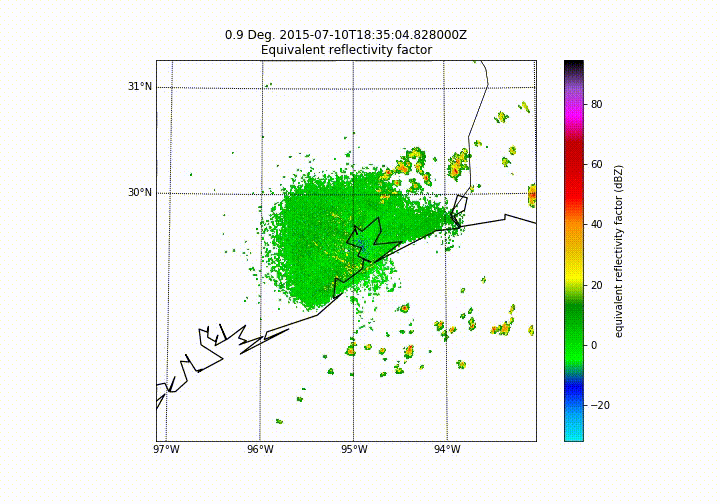

In [6]:
# We can visualize this data using pyart and matplotlib
fig = plt.figure(figsize=(10, 7))


def plot_ppi(key):
    """ Plots ppi map of nexrad data given S3 key. """
    plt.clf()
    radar = read_nexrad_key(key)
    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi_map('reflectivity', resolution='l',
                         sweep=3, fig=fig, width=400000, height=400000)
    del display, radar


ppi_anim = FuncAnimation(fig, plot_ppi, frames=keys, interval=1000)
tmp_anim = tempfile.NamedTemporaryFile()
ppi_anim.save(tmp_anim.name + '.mp4', writer='ffmpeg')
embed_mp4_as_gif(tmp_anim.name + '.mp4')
os.remove(tmp_anim.name + '.mp4')

In [5]:
display?


## 2. GRID

### Disclaimer
If you are running this notebook and don't want this data to remain on your filesystem, make sure you run the last cell in the notebook. If your kernel crashes for some reason, you can manually remove the the path printed after the following cell.

In [4]:
# Looks like there are some interesting cells coming off the gulf.
# Let's make a function that maps these volumes to cartesian grids using pyart.
# Most of the cells seem to be in the bottom right quadrant, so we'll only grid
# that part of the domain to save time.

def get_grid(radar):
    """ Returns grid object from radar object. """
    grid = pyart.map.grid_from_radars(
        radar, grid_shape=(31, 401, 401),
        grid_limits=((0, 15000), (-200000, 0), (0, 200000)),
        fields=['reflectivity'], gridding_algo='map_gates_to_grid',
        h_factor=0., nb=0.6, bsp=1., min_radius=200.)
    return grid


# Let's write these grids to a temporary location so that we can reuse them.
# This might take a few minutes
tmp_dir = tempfile.mkdtemp()
print('temporary directory:', tmp_dir)
filenames = []
for num, key in enumerate(keys):
    print('saving grid', num)
    radar = read_nexrad_key(key)
    grid = get_grid(radar)
    name = os.path.join(tmp_dir, 'grid_' + str(num).zfill(3) + '.nc')
    filenames.append(name)
    pyart.io.write_grid(name, grid)
    del radar, grid

temporary directory: /tmp/tmp51odqjcc
saving grid 0
saving grid 1
saving grid 2
saving grid 3
saving grid 4
saving grid 5
saving grid 6
saving grid 7
saving grid 8
saving grid 9
saving grid 10
saving grid 11
saving grid 12


In [5]:
# Now we can easily instantiate generators of these grids like so
grids = (pyart.io.read_grid(fn) for fn in filenames)

## 3. TRACK

In [6]:
# First, let's instantiate a tracks object and view the default parameters
tracks_obj = Cell_tracks()
tracks_obj.params

{'FIELD_THRESH': 32,
 'FLOW_MARGIN': 10000,
 'GS_ALT': 1500,
 'ISO_SMOOTH': 3,
 'ISO_THRESH': 8,
 'MAX_DISPARITY': 999,
 'MAX_FLOW_MAG': 50,
 'MAX_SHIFT_DISP': 15,
 'MIN_SIZE': 8,
 'SEARCH_MARGIN': 4000}

In [7]:
# The cells we're interested in look a bit small. Let's reduce the minimum size threshold.
tracks_obj.params['MIN_SIZE'] = 4
# We'll give the generator of grids we made earlier to the get_tracks method of our tracks object.
tracks_obj.get_tracks(grids)

Writing tracks for scan 0
Writing tracks for scan 1
Writing tracks for scan 2
Writing tracks for scan 3
Writing tracks for scan 4
Writing tracks for scan 5
Writing tracks for scan 6
Writing tracks for scan 7
Writing tracks for scan 8
Writing tracks for scan 9
Writing tracks for scan 10
Writing tracks for scan 11
Writing tracks for scan 12


time elapsed 0.2 minutes


In [8]:
# Now we can view the 'tracks' attribute of our tracks object to see the results.
tracks_obj.tracks.head(20)

area   grid_x   grid_y isolated      lat      lon        max  \
scan uid                                                                  
0    0     8.50  243.176  160.294     True  28.3870 -93.8368  42.666893   
     1    12.75    9.353  186.588    False  28.5141 -95.0327  41.691734   
     2    28.00  132.804  191.464    False  28.5304 -94.3981  49.863377   
     3     6.50   75.346  189.423     True  28.5226 -94.6949  41.088482   
     4    54.00  333.875  235.005    False  28.7190 -93.3662  47.321583   
     5    23.00  388.000  232.674     True  28.7062 -93.0895  42.495949   
     6    20.50  310.732  233.744    False  28.7160 -93.4842  48.063313   
     7     9.25  223.622  233.541    False  28.7205 -93.9302  45.998070   
     8    11.25  265.644  240.956    False  28.7500 -93.7145  47.989941   
     9    10.25  198.780  244.732     True  28.7710 -94.0579  47.172390   
     10    4.25  263.294  251.529    False  28.7996 -93.7292  35.878952   
     11    5.50  346.455  253.364    False  28.7991 -93.3033  37.381847   
     12   15.00  348.067  275.233    False  28.8979 -93.2913  42.841267   
     13   16.25  122.400  278.046     True  28.9218 -94.4520  49.762119   
     14    4.25  289.824  339.000     True  29.1893 -93.5850  38.054726   
1    15    4.50  105.278  150.500     True  28.3467 -94.5423  44.995056   
     16    6.75  157.741  154.519     True  28.3678 -94.2714  39.080887   
     0     7.25  241.517  161.793    False  28.3960 -93.8418  41.356609   
     1     8.25    7.273  187.727    False  28.5186 -95.0429  39.393646   
     2    29.75  131.445  192.571    False  28.5394 -94.4082  50.227661   

          max_alt                time      vol  
scan uid                                        
0    0        4.5 2015-07-10 18:34:06   15.500  
     1        4.0 2015-07-10 18:34:06   33.500  
     2        5.5 2015-07-10 18:34:06   92.750  
     3        3.5 2015-07-10 18:34:06   11.000  
     4        7.0 2015-07-10 18:34:06  164.125  
     5        5.5 2015-07-10 18:34:06   34.500  
     6        6.0 2015-07-10 18:34:06   59.375  
     7        6.5 2015-07-10 18:34:06   30.500  
     8        6.0 2015-07-10 18:34:06   32.875  
     9        4.5 2015-07-10 18:34:06   23.875  
     10       2.5 2015-07-10 18:34:06    3.000  
     11       2.5 2015-07-10 18:34:06    3.500  
     12       4.5 2015-07-10 18:34:06   27.750  
     13       5.5 2015-07-10 18:34:06   49.625  
     14       3.5 2015-07-10 18:34:06    7.750  
1    15       4.0 2015-07-10 18:38:24    9.125  
     16       4.0 2015-07-10 18:38:24   11.625  
     0        4.5 2015-07-10 18:38:24   12.125  
     1        4.0 2015-07-10 18:38:24   17.125  
     2        5.0 2015-07-10 18:38:24   89.000

## 4. VISUALIZE

In [9]:
# We can visualize these tracks to assess the performance of the algorithm.
# First we need to make another generator of the same grids for the animator
grids = (pyart.io.read_grid(fn) for fn in filenames)

In [10]:
# Let's save the animation in our temp directory so that it will be cleaned up later.
animate(tracks_obj, grids, os.path.join(tmp_dir, 'tint_demo_anim'))

Animating 13 frames
Frame: 0
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9
Frame: 10
Frame: 11
Frame: 12


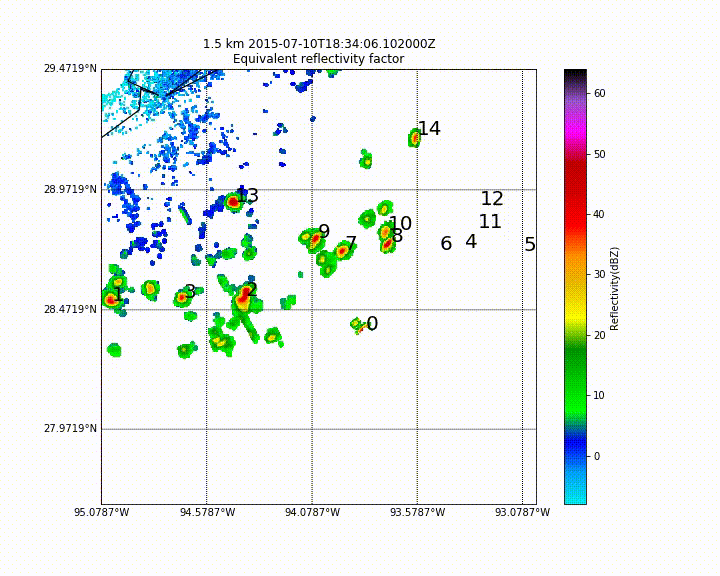

In [11]:
# The animator saved an mp4 to our local directory. Now we can embed it as a gif in this notebook.
embed_mp4_as_gif(os.path.join(tmp_dir, 'tint_demo_anim.mp4'))

In [12]:
# Let's find the cells that were tracked for the most frames
tracks_obj.tracks.groupby(level='uid').size().sort_values(ascending=False)[:5]

uid
0     13
3     13
4     13
16    12
19    10
dtype: int64

In [13]:
# Now we can view these cells from a lagrangian perspective
grids = (pyart.io.read_grid(fn) for fn in filenames)  # refresh grid generator
animate(tracks_obj, grids, os.path.join(tmp_dir, 'tint_demo_lagrangian'), style='lagrangian', uid='0', alt=2000)

Animating 13 frames
Frame: 0
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9
Frame: 10
Frame: 11
Frame: 12


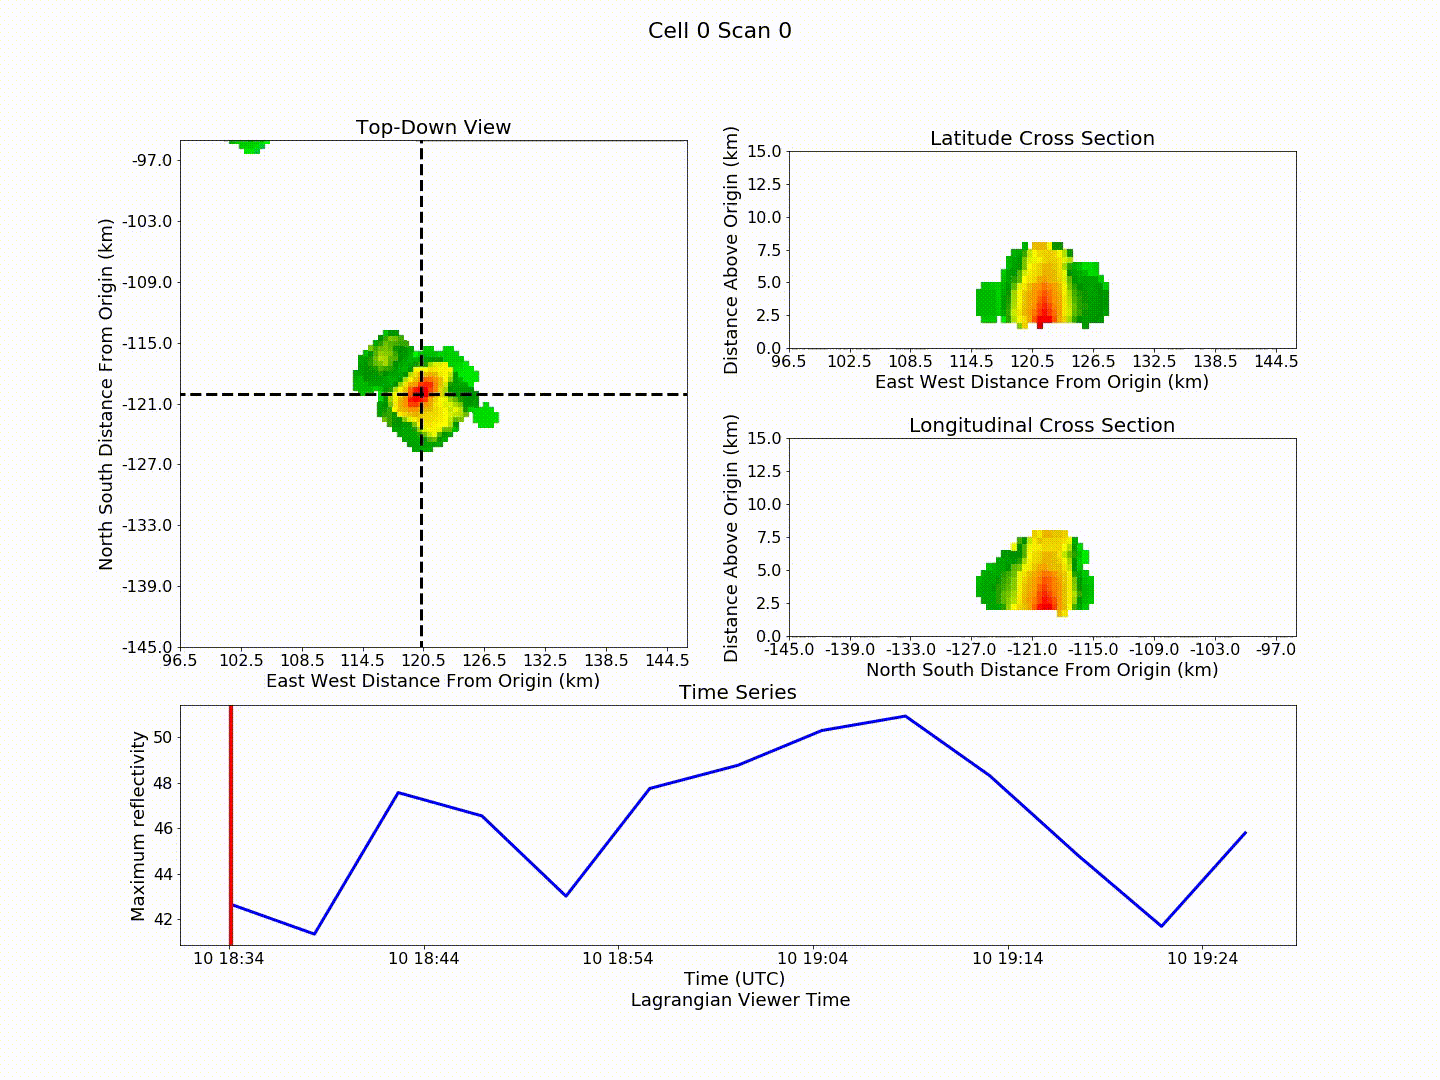

In [14]:
embed_mp4_as_gif(os.path.join(tmp_dir, 'tint_demo_lagrangian.mp4'))

In [15]:
# We can view the attributes of this cell throughout its lifetime
tracks_obj.tracks.xs('0', level='uid')

,area,grid_x,grid_y,isolated,lat,lon,max,max_alt,time,vol
scan,,,,,,,,,,
0,8.50,243.176,160.294,True,28.3870,-93.8368,42.666893,4.5,2015-07-10 18:34:06,15.500
1,7.25,241.517,161.793,False,28.3960,-93.8418,41.356609,4.5,2015-07-10 18:38:24,12.125
2,14.25,234.281,169.439,True,28.4278,-93.8823,47.569710,4.5,2015-07-10 18:42:42,34.250
3,14.75,232.831,169.305,True,28.4279,-93.8874,46.546608,4.5,2015-07-10 18:47:00,37.125
4,14.75,230.814,170.017,True,28.4325,-93.8976,43.021122,4.5,2015-07-10 18:51:19,30.125
5,21.25,228.106,172.176,True,28.4416,-93.9128,47.750134,5.0,2015-07-10 18:55:37,52.625
6,28.50,225.377,174.316,True,28.4507,-93.9281,48.770603,5.5,2015-07-10 19:00:09,79.750
7,27.75,222.928,176.775,True,28.4643,-93.9381,50.294968,6.5,2015-07-10 19:04:27,85.375
8,26.25,220.943,179.105,True,28.4734,-93.9483,50.929752,7.0,2015-07-10 19:08:45,92.125


## Clean Up

In [ ]:
# Now we can delete the directory containing all the data and output from this demo.
shutil.rmtree(tmp_dir)
print('temporary directory removed')